In [1]:
import acquire
import prep
import split_scale

import seaborn as sns

In [2]:
import pandas as pd

# read sql data from csv to minimize lag
# df = pd.read_csv(r'/Users/mists/codeup-data-science/zillow-cluster/query_result.csv')
df = pd.read_csv(r'/Users/cris/codeup-data-science/zillow-cluster/query_result.csv')

In [3]:
# wrangle_zillow code here
df = acquire.wrangle_zillow(df)

In [4]:
df = prep.handle_missing_values(df,.90,.40)

In [5]:
df = prep.clean_columns(df)

In [6]:
df = prep.drop_minimal_nulls(df)

In [7]:
df = prep.pretty_cols(df)

In [8]:
df = prep.cal_taxrate(df)

In [9]:
df.transactiondate = pd.to_datetime(df.transactiondate)
df.countyid = df.countyid.astype("category")

In [10]:
train, test = split_scale.split_my_data(df, .80)

In [11]:
train, test = prep.impute_lotsize_nulls(train, test)

In [12]:
train = prep.cal_land_area(train)
test = prep.cal_land_area(test)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41680 entries, 28235 to 54472
Data columns (total 15 columns):
countyid           41680 non-null category
latitude           41680 non-null int64
longitude          41680 non-null int64
yearbuilt          41680 non-null float64
bathroomcnt        41680 non-null float64
bedroomcnt         41680 non-null int64
house_area         41680 non-null float64
house_value        41680 non-null float64
land_value         41680 non-null float64
whole_area         41680 non-null float64
whole_value        41680 non-null float64
logerror           41680 non-null float64
transactiondate    41680 non-null datetime64[ns]
taxrate            41680 non-null float64
land_area          41680 non-null float64
dtypes: category(1), datetime64[ns](1), float64(10), int64(3)
memory usage: 6.1 MB


---

In [14]:
#transaction date is removed in train (for exploration purposes)
trex = train.copy()
trex = trex.drop(columns="transactiondate")

teex = test.copy()
teex = teex.drop(columns="transactiondate")

In [39]:
trex, teex, scaler = split_scale.iqr_robust_scaler(trex, teex)

trex is train:
    - without the transaction date
    - scaled to normal distribution

In [40]:
trex_home = trex[["logerror","bathroomcnt","bedroomcnt","house_area","land_area","whole_area","yearbuilt"]]
trex_loc = trex[["logerror","latitude","longitude","countyid"]]
trex_val = trex[["logerror","house_value","land_value","whole_value","taxrate"]]

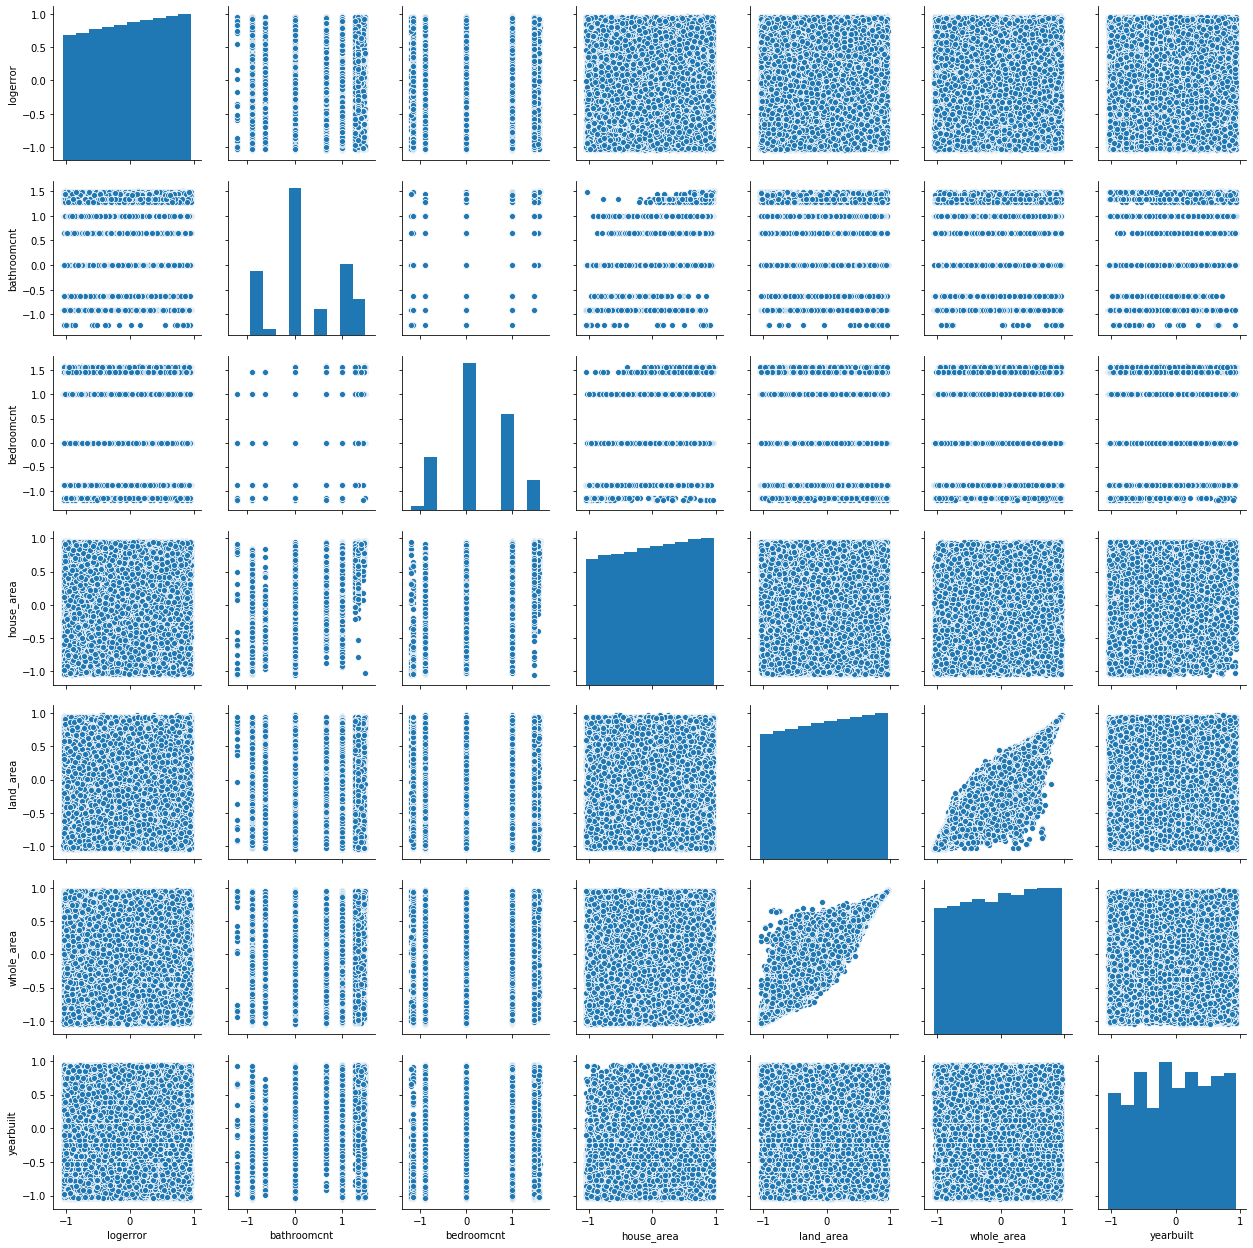

In [41]:
sns.pairplot(trex_home)

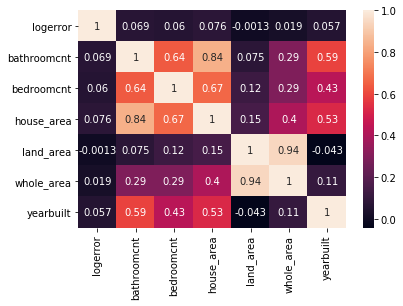

In [42]:
sns.heatmap(trex_home.corr(), annot=True)

`bathroomcnt` and `bedroomcnt` have strong positive correlation with `house_area`. These features can be dropped. Likewise, `land_area` is a derivative of the data we know previously which was `whole_area` (prev. lotsize) so they're very strongly correlated. We can drop the `whole_area` for now.
  
Recall that `land_area` is a derived feature from finished sqft and lot size. We inferred that a big house, does not always entail a big land which is why we separated land and house area in the first place. Seeing a low (0.15) correlation between `land_area` and `house_area` confirms that it was a good move to separate these features.
  
It's also interesting to note that `house_area` has a fairly strong positive correlation with `yearbuilt` and it's probably due to the style of house built during that era (craftsman, neoclassical, ranch style, etc.). Even if they are correlated, year built provides a distinct information on the property so we will keep it.

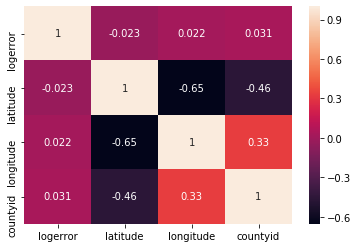

In [43]:
sns.heatmap(trex_loc.corr(),annot=True)

No correlations stand out from the house group, but it's worth noting that `latitude` and `longitude` have strong negative correlation. It means that as we move eastwards, we move southwards, which geographically makes sense as we are considering counties in Los Angeles (forms a downsloping diagonal line).

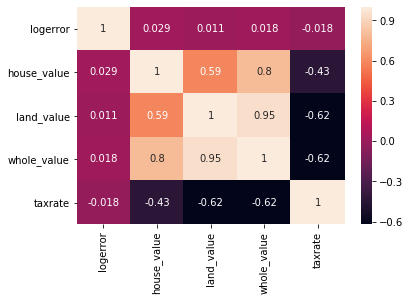

In [44]:
sns.heatmap(trex_val.corr(),annot=True)

`whole_value` is the sum of `land_value` and `house_value`, so a positive high correlation of .95 and .8 is expected. We can drop `whole_value` as a feature for the model.
  
The `tax_rate` having strong negative correlations with `land_value` is something to note.

<div class="alert alert-block alert-info">
<b>TAKEAWAY:</b>  
    
- None of the features seem to highly correlate with logerror. But it makes me think that its possibly because of two things:
    1. Logerror is a derived feature. It's not as straightforward as property value.
    2. Logerror is drived by a summation of different things, random and predictable. It's a multi-dimensional problem that needs more than x predicts y.
- Pearson's r does not show statistical significance. Instead of thinking that none of these features drive logerror, it strengthens the idea of exploring clustering more to address the dimensionality of the features.
- With the above being said, instead of using pearson's r to both (1) see strong drivers in explaining logerror, and (2) check for multicollinear features, we will only use it to address multicollinearity and inform us what features to drop.
- **Features to Keep based on Pearson's Correlation**
 - House Group  
   - land_area  
   - house_area  
   - year_built  
 - Location Group  
   - latitude  
   - longitude  
   - county_id  
 - Valuation Group  
   - house_value  
   - land_value  
   - taxrate  
</div>